Incoporating feedback from multiple experts seems absurdly obvious, but is that so? Let us find out.

In [230]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from graphviz import Digraph
import torch.nn as nn
from scipy.interpolate import interp1d
import torch

fontsize=15

# Why do we need feedback? Underspecification

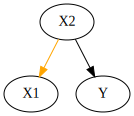

In [29]:
dot = Digraph()
dot.node('1', 'X1')
dot.node('2', 'X2')
dot.node('y', 'Y')

dot.edge('2', 'y')
dot.edge('2', '1', color='orange')
dot

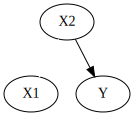

In [30]:
dot = Digraph()
dot.node('1', 'X1')
dot.node('2', 'X2')
dot.node('y', 'Y')

dot.edge('2', 'y')
dot.edge('2', '1', color='white')
dot

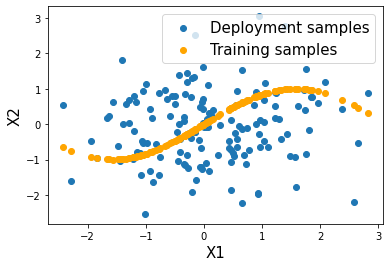

In [107]:
x = np.random.randn(300).reshape(-1, 2)
f = lambda x: np.sin(x)
plt.scatter(x[:, 0], x[:, 1], label='Deployment samples')#, color='white')
plt.scatter(x[:, 0], f(x[:, 0]), c='orange', label='Training samples')
plt.xlabel('X1', fontsize=fontsize)
plt.ylabel("X2", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

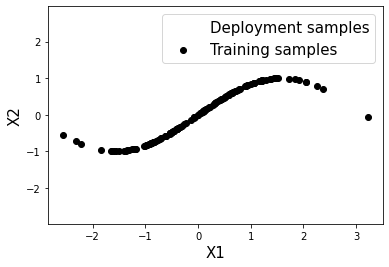

In [108]:
x = np.random.randn(300).reshape(-1, 2)
f = lambda x: np.sin(x)
plt.scatter(x[:, 0], x[:, 1], label='Deployment samples', color='white')
plt.scatter(x[:, 0], f(x[:, 0]), c='black', label='Training samples')
plt.xlabel('X1', fontsize=fontsize)
plt.ylabel("X2", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

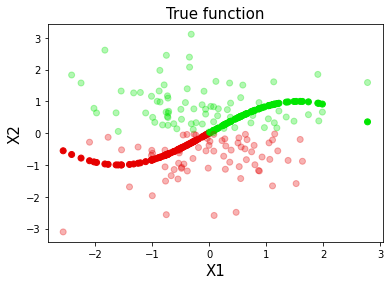

In [87]:
x = np.random.randn(300).reshape(-1, 2)
f = lambda x: np.sin(x)
x1 = x[:, 0]
x2 = f(x[:, 0])
f2 = lambda x1, x2: x2 > 0
colors = np.array([(0.9,0.,0.,1), (0.,0.9, 0.,1)])
fade_colors = np.array([(0.9,0.,0.,0.3), (0.,0.9, 0.,0.3)])
plt.scatter(x[:, 0], x2, c=colors[f2(x1, x2).astype(int)])
plt.scatter(x[:, 0], x[:, 1], c=fade_colors[f2(x[:,0], x[:,1]).astype(int)])

plt.xlabel('X1', fontsize=fontsize)
plt.ylabel("X2", fontsize=fontsize)
plt.title('True function', fontsize=fontsize)
plt.show()

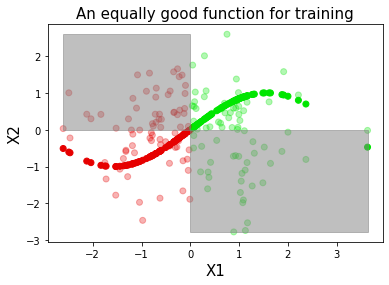

In [103]:
x = np.random.randn(300).reshape(-1, 2)
f = lambda x: np.sin(x)
x1 = x[:, 0]
x2 = f(x[:, 0])
f2 = lambda x1, x2: x1 > 0
colors = np.array([(0.9,0.,0.,1), (0.,0.9, 0.,1)])
fade_colors = np.array([(0.9,0.,0.,0.3), (0.,0.9, 0.,0.3)])
plt.scatter(x[:, 0], x2, c=colors[f2(x1, x2).astype(int)])
plt.scatter(x[:, 0], x[:, 1], c=fade_colors[f2(x[:,0], x[:,1]).astype(int)])

plt.xlabel('X1', fontsize=fontsize)
plt.ylabel("X2", fontsize=fontsize)
plt.title('An equally good function for training', fontsize=fontsize)

rect = Rectangle((x[:,0].min(),0), np.abs(x[:,0].min()), x[:,1].max(), color=(0.5,0.5,0.5,0.5))
plt.gca().add_patch(rect)

rect = Rectangle((0, x[:,1].min()), np.abs(x[:,0].max()), np.abs(x[:,1].min()), color=(0.5,0.5,0.5,0.5))
plt.gca().add_patch(rect)

plt.show()

# The different forms of regularization

In [258]:
thetas = nn.Parameter(torch.randn(len(x)))
# thetas[0].unsqueeze(0), thetas[1:]
deltas = torch.cat([thetas[0].unsqueeze(0), thetas[1:].exp()])
# deltas.cumsum(0)
torch.from_numpy
# deltas[1:] = deltas[1:].exp()
# deltas, thetas

<function _VariableFunctionsClass.from_numpy>

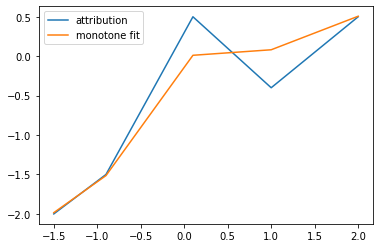

In [272]:
def monotone_interp(x, y, silent=True, niter=1000):
    '''
    given x, y of the same shape, return best monotone fit points y_hat
    that is monotone increasing
    assume x is sorted
    '''
    thetas = torch.nn.Parameter(torch.randn(len(x)))
    
    opt = torch.optim.SGD([thetas], lr=0.01)
    for i in range(niter):
        deltas = torch.cat([thetas[0].unsqueeze(0), thetas[1:].exp()])
        yhat = deltas.cumsum(0)
        
        opt.zero_grad()
        l = torch.sum((y-yhat)**2)
        if not silent and i % 100 == 0:
            print(l)
        l.backward()
        opt.step()
        
    return yhat

yhat = monotone_interp(torch.from_numpy(rationale), torch.from_numpy(attribution))

plt.plot(rationale, attribution, label='attribution')
plt.plot(rationale, yhat.detach().numpy(), label='monotone fit')
plt.legend()
plt.show()
        

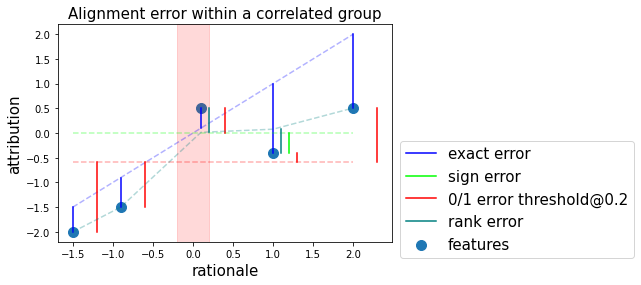

In [278]:
rationale = np.array([-1.5, -0.9, 0.1, 1, 2])
attribution = np.array([-2, -1.5, 0.5, -0.4, 0.5])
plt.scatter(rationale, attribution, s=100, label='features')
plt.xlabel('rationale', fontsize=fontsize)
plt.ylabel('attribution', fontsize=fontsize)

step = 0.1
alpha = 0.3

# exact error
color = [0, 0, 1]
plt.plot([rationale[0], rationale[-1]], [rationale[0], rationale[-1]], marker='None', ls='--', c=color + [alpha]) # y=x line
for i, (r, a) in enumerate(zip(rationale, attribution)):
    if i == 0:
        plt.plot([r,r], [a,r], c=color, ls='-', label='exact error')
    else:
        plt.plot([r,r], [a,r], c=color, ls='-')
        
# sign
color = [0, 1, 0]
margin = 0
plt.plot([rationale[0], rationale[-1]], [0, 0], marker='None', ls='--', c=color + [alpha])
first = True
for r, a in zip(rationale, attribution):
    if r * a < margin:
        if first:
            plt.plot([r+2*step,r+2*step], [a, margin if a < 0 else -margin], c=color, ls='-', label='sign error')
        else:
            plt.plot([r+2*step,r+2*step], [a, margin if a < 0 else -margin], c=color, ls='-')
        first = False
        
# 0/1
color = [1, 0, 0]
margin = 0.2
plt.axvspan(-margin, margin, alpha=alpha/2, color=color)
line = sum(attribution) / len(np.abs(rationale) > margin)
plt.plot([rationale[0], rationale[-1]], [line, line], marker='None', ls='--', c=color + [alpha])
first = True
for r, a in zip(rationale, attribution):
    target = 0
    if abs(r) > margin:
        target = line
    if first:
        plt.plot([r+3*step,r+3*step], [a, target], c=color, ls='-', label=f'0/1 error threshold@{margin}')
    else:
        plt.plot([r+3*step,r+3*step], [a, target], c=color, ls='-')
    first = False
        
# rank
color = [0, 0.5, 0.5]
line = monotone_interp(torch.from_numpy(rationale), torch.from_numpy(attribution)).detach().numpy()
plt.plot(rationale, line, marker='None', ls='--', c=color + [alpha])
first = True
for r, a, m in zip(rationale, attribution, line):
    target = 0
    if first:
        plt.plot([r+step,r+step], [a, m], c=color, ls='-', label=f'rank error')
    else:
        plt.plot([r+step,r+step], [a, m], c=color, ls='-')
    first = False

plt.legend(fontsize=fontsize, bbox_to_anchor=(1,0.5))
plt.title('Alignment error within a correlated group', fontsize=fontsize)
plt.show()

# Don't rely on one person's opinion too much? Incoporating multiple feedbacks

$X_i$ := the $i^{\text{th}}$ chosen expert is correct

Assume we have a binary classification problem.

## Assume $X_i$ are independent

In [442]:
p1 = 0.1 # the model is right for the right reason 0.1
p2 = 0.2 # the expert has the right reasoning, 0.2
p3 = 0.1 # the expert has the wrong but compatible reasoning 0.1
d1 = 0.9 # the model's deployment accuracy when right for the right reason 0.9
d2 = 0.55 # the model's deployment accuracy when right for the wrong reason 0.55

t1 = 0.95 # the model's traing accuracy when right for the right reason
t2 = 0.95 # the model's training accuracy when right for the wrong reason

rw_error_base=0.3

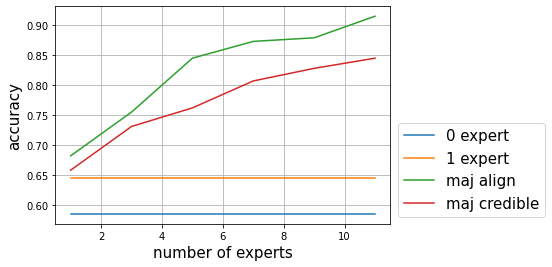

In [443]:
# 0 expert: regular training P(X=1) = sum_{type=rr,rw} P(the expert is of type) P(X=1|the expert is type) 
acc_0_expert = p1 * d1 + (1-p1) * d2

# 1 expert: credible learning
acc_1_expert = (p2 + (1-p2-p3)*p1) * d1 + (p3 + (1-p2-p3)*(1-p1)) * d2

# majority of credible experts
def maj_credible(m=10):
    nruns = 1000
    head = 0
    for i in range(nruns):
        # P(X_i = 1)
        p = (p2 + (1-p2-p3)*p1) * d1 + (p3 + (1-p2-p3)*(1-p1)) * d2
        x = np.random.choice(2, m, p=[1-p, p])
        head += (x.mean() >= 0.5)
    acc_maj_credible = head / nruns
    return acc_maj_credible

# majority of aligned experts
def maj_align(m=10):
    nruns = 1000
    head = 0
    for i in range(nruns):
        expert_type = np.random.choice(3, m, p=[p2, 1-p2-p3, p3])
        n_rr = sum(expert_type == 0)
        n_rw = sum(expert_type == 2)
        n_mixed = sum(expert_type == 1)
        x_rr = np.random.choice(2, n_rr, p=[1-d1, d1])
        x_rw = np.random.choice(2, n_rw, p=[1-d2, d2])
        x = np.hstack([x_rr, x_rw])
            
        if len(x) == 0:
            p = p1 * d1 + (1-p1) * d2
            x = np.random.choice(2, n_mixed, p=[1-p, p])
        
        head += (x.mean() >= 0.5)

    acc_maj_credible = head / nruns
    return acc_maj_credible


n_experts = [1,3,5,7,9,11]
acc_maj_credible = list(map(maj_credible, n_experts))
acc_maj_align = list(map(maj_align, n_experts))

plt.plot(n_experts, np.ones_like(n_experts) * acc_0_expert, label='0 expert')
plt.plot(n_experts, np.ones_like(n_experts) * acc_1_expert, label='1 expert')

plt.plot(n_experts, acc_maj_align, label='maj align')
plt.plot(n_experts, acc_maj_credible, label='maj credible')
plt.xlabel('number of experts', fontsize=fontsize)
plt.ylabel('accuracy', fontsize=fontsize)
plt.grid()
plt.legend(fontsize=fontsize, bbox_to_anchor=(1,0.5))
plt.show()


What force is driving it? ensemble or the good expert? what if p1 < 0.5? mixture of priors would need to impose all constraints

## $X_i$'s are not independent: RW has a upper accuracy constraint

This would realistically model the fact that ensemble of wrong models cannot reach perfect accuracy

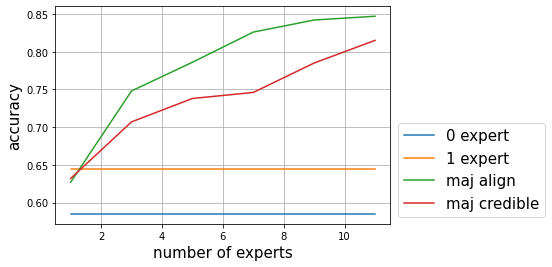

In [444]:
# 0 expert: regular training P(X=1) = sum_{type=rr,rw} P(the expert is of type) P(X=1|the expert is type) 
acc_0_expert = p1 * d1 + (1-p1) * d2

# 1 expert: credible learning
acc_1_expert = (p2 + (1-p2-p3)*p1) * d1 + (p3 + (1-p2-p3)*(1-p1)) * d2

# majority of credible experts
def maj_credible(m=10):
    nruns = 1000
    head = 0
    for i in range(nruns):
        expert_type = np.random.choice(3, m, p=[p2, 1-p2-p3, p3])
        n_rr = sum(expert_type == 0)
        n_rw = sum(expert_type == 2)
        n_mixed = sum(expert_type == 1)
        x_rr = np.random.choice(2, n_rr, p=[1-d1, d1])
        
        if np.random.rand() < rw_error_base:
            x_rw = np.zeros(n_rw) # limit the number of correct
        else:
            x_rw = np.random.choice(2, n_rw, p=[1-d2, d2])
        
        p = p1 * d1 + (1-p1) * d2 # p(x_mixed=1)
        x_mixed = np.random.choice(2, n_mixed, p=[1-p, p])
        x = np.hstack([x_rr, x_rw, x_mixed])
                    
        head += (x.mean() >= 0.5)
        
    acc_maj_credible = head / nruns
    return acc_maj_credible

# majority of aligned experts
def maj_align(m=10):
    nruns = 1000
    head = 0
    for i in range(nruns):
        expert_type = np.random.choice(3, m, p=[p2, 1-p2-p3, p3])
        n_rr = sum(expert_type == 0)
        n_rw = sum(expert_type == 2)
        n_mixed = sum(expert_type == 1)
        x_rr = np.random.choice(2, n_rr, p=[1-d1, d1])
        
        if np.random.rand() < rw_error_base:
            x_rw = np.zeros(n_rw) # limit the number of correct
        else:
            x_rw = np.random.choice(2, n_rw, p=[1-d2, d2])
            
        x = np.hstack([x_rr, x_rw])
            
        if len(x) == 0:
            p = p1 * d1 + (1-p1) * d2
            x = np.random.choice(2, n_mixed, p=[1-p, p])
        
        head += (x.mean() >= 0.5)

    acc_maj_credible = head / nruns
    return acc_maj_credible


n_experts = [1,3,5,7,9,11]
acc_maj_credible = list(map(maj_credible, n_experts))
acc_maj_align = list(map(maj_align, n_experts))

plt.plot(n_experts, np.ones_like(n_experts) * acc_0_expert, label='0 expert')
plt.plot(n_experts, np.ones_like(n_experts) * acc_1_expert, label='1 expert')

plt.plot(n_experts, acc_maj_align, label='maj align')
plt.plot(n_experts, acc_maj_credible, label='maj credible')
plt.xlabel('number of experts', fontsize=fontsize)
plt.ylabel('accuracy', fontsize=fontsize)
plt.grid()
plt.legend(fontsize=fontsize, bbox_to_anchor=(1,0.5))
plt.show()


# Incorporating high level concepts as feedback

## Why would raw feature attribution based methods fail?

Because high level information may be distributed in the same spatial region. See rudin 2019 for an example. We can simulate this by randomly projecting concepts.

## Why would concept discovery interpretation fail?

Because the network is not forced to use the concept. The network wouldn't prioritize over interpretable concepts, thus it is unlikely the high level concepts are faithful. We can simulate this by showing a neuron that activate when multiple concepts are present (overloaded and thus cannot be separated).

## Why would jointly trained concept bottleneck model (CBM) fail?

Because it can hide non-interpretable information within interpretable detector.

## Solution

1. Train CBM separately on diverse concept datasets
2. Have a channel to allow non-interpetable information to pass through
3. Use EYE penalty to do feature selection (preferring interpretable features)

## Simulation study (a linear sanity check)

$Z \sim N(0, I_{10}))$ are 10 real concepts

$X = Rotate(Z)$ is a random projection of concepts presented to the human

$X \rightarrow C \rightarrow X$ where $C \in \mathbb{R}^9$ is concept detectors

$Y = \theta Z$ where $\theta$ is the true coefficient.

This setup will fail feature attribution (because $X$ distribute concepts across dimensions), concept discovery (when the function is a or concept), jointly trained concept (because $C$ has 1 less dimension off $Z$).